In [1]:
import numpy as np 
import scanpy as sc 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import anndata as ad 
import scanpy.external as sce 

In [2]:
scdata = sc.read_h5ad('final_hvg.h5ad')
scdata

AnnData object with n_obs × n_vars = 26222 × 2670
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype', 'coarse_celltype', 'eco'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'eco_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
new_idx = []
for ele in scdata.obs.index.values:
    a,b,c = ele.split('-')
    species = a.split('HM')[0].lower()
    new_idx.append(species+'_'+b+'-'+c)
new_idx = np.array(new_idx)

scdata.obs.index = new_idx

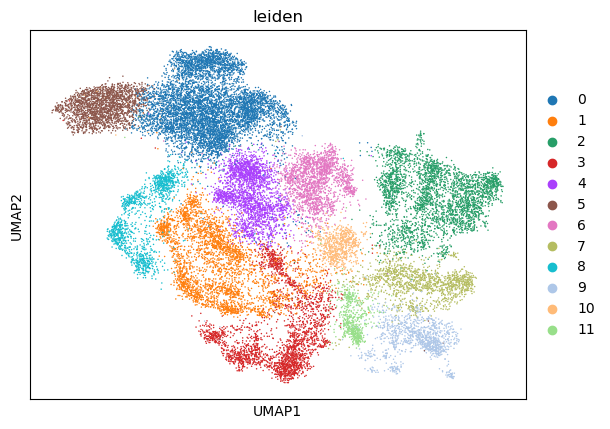

In [5]:
sc.pl.umap(scdata, color = 'leiden')

In [2]:
save_dir = 'data'
scdata = sc.read_h5ad(os.path.join(save_dir, 'hmdata_raw_1.h5ad'))
scdata.raw = scdata

eco_dic = {'CY': 'eco',
           'JT': 'eco',
           'QF': 'non-eco',
           'M': 'non-eco',
           'T': 'eco'}

scdata.obs.loc[:,'eco'] = scdata.obs.species.map(eco_dic)


sc.tl.rank_genes_groups(scdata, 'eco', method='wilcoxon')

deg_df = pd.DataFrame(scdata.uns['rank_genes_groups']['names'])

sel_gene = np.concatenate([deg_df.iloc[:1000,0].values, deg_df.iloc[:1000,1].values])
sel_gene = np.unique(sel_gene)
print(sel_gene.shape)

sc.pp.highly_variable_genes(scdata, n_top_genes=1000)
hvg = scdata.var.index.values[scdata.var.highly_variable]

sel_gene = np.concatenate([hvg, sel_gene])
sel_gene = np.unique(sel_gene)
print(sel_gene.shape)

neuron = scdata[scdata.obs.cluster == 'neuron']
neuron = neuron[:,sel_gene]
print(neuron.shape)

(2000,)
(2670,)
(26567, 2670)


In [3]:

def pipe_1(scdata, sigma = 0.1, theta = 1.5, regular = True):
    if regular:
        sc.tl.pca(scdata)
        sc.pl.pca(scdata, color = ['species', 'celltype'])
        sc.pp.neighbors(scdata)
        sc.tl.umap(scdata)
        sc.pl.umap(scdata, color = ['species', 'celltype'])
    sce.pp.harmony_integrate(scdata, 'species', max_iter_harmony = 20, sigma = sigma, random_state = 0,theta = theta)#theta = 2)
    sc.pl.embedding(scdata, basis = 'X_pca_harmony', color = ['species','celltype'])
    sc.pp.neighbors(scdata, use_rep= 'X_pca_harmony')
    sc.tl.umap(scdata)
    sc.pl.umap(scdata, color = ['species','celltype'])

    eco_dic = {'CY': 'eco',
            'JT': 'eco',
            'QF': 'non-eco',
            'M': 'non-eco',
            'T': 'eco'}

    scdata.obs.loc[:,'eco'] = scdata.obs.species.map(eco_dic)
    sc.pl.umap(scdata, color = 'eco')
    return scdata 

def count_summary(neuron, key_1 , key_2 = 'samples'):
        anno_df = neuron.obs.copy()
        anno_df.head()

        df = anno_df 
        # 1. 按col1和col2分组，统计每个组合的数量
        grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')

        # 2. 按col1分组，计算总数
        total_counts = df.groupby(key_2).size().reset_index(name='total_count')

        # 3. 合并数据，计算比例
        merged = grouped.merge(total_counts, on=key_2)
        merged['proportion'] = merged['count'] #/ merged['total_count']

        # 4. 重新排序和格式化结果
        result = merged[[key_2, key_1, 'proportion']]

        result = result.pivot(index=key_1, columns=key_2, values='proportion')
        return result

print('utils code')

utils code


d:\Anaconda\envs\scanpy-1.10\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


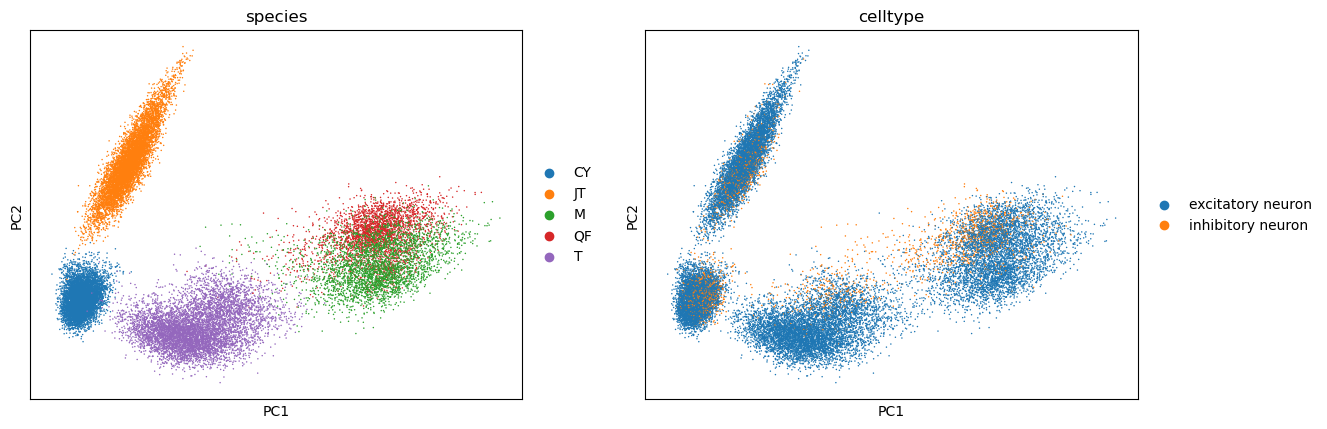

d:\Anaconda\envs\scanpy-1.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


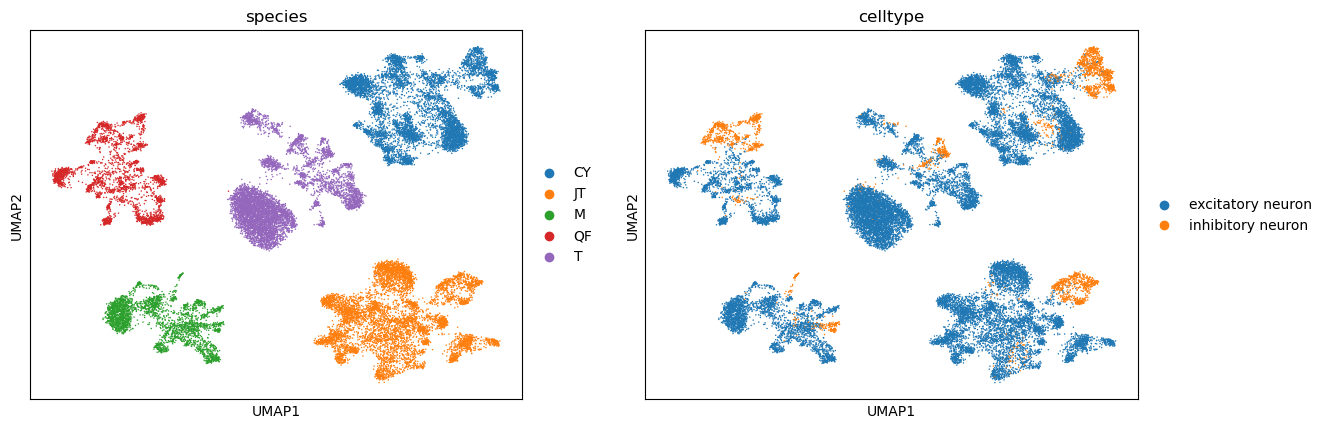

2024-12-18 13:49:39,552 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-18 13:49:42,909 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-18 13:49:43,178 - harmonypy - INFO - Iteration 1 of 20
2024-12-18 13:49:53,003 - harmonypy - INFO - Iteration 2 of 20
2024-12-18 13:50:02,778 - harmonypy - INFO - Converged after 2 iterations


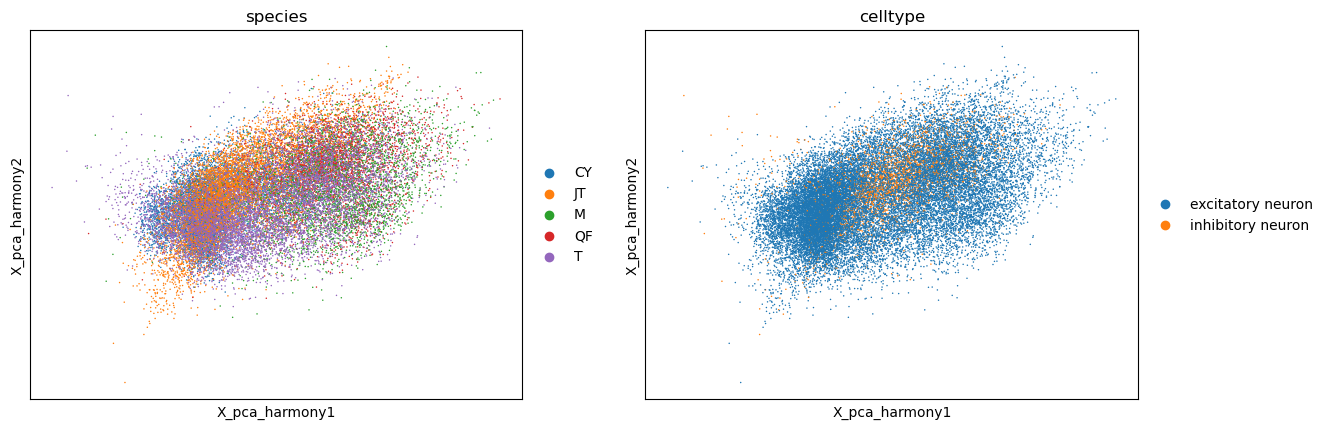

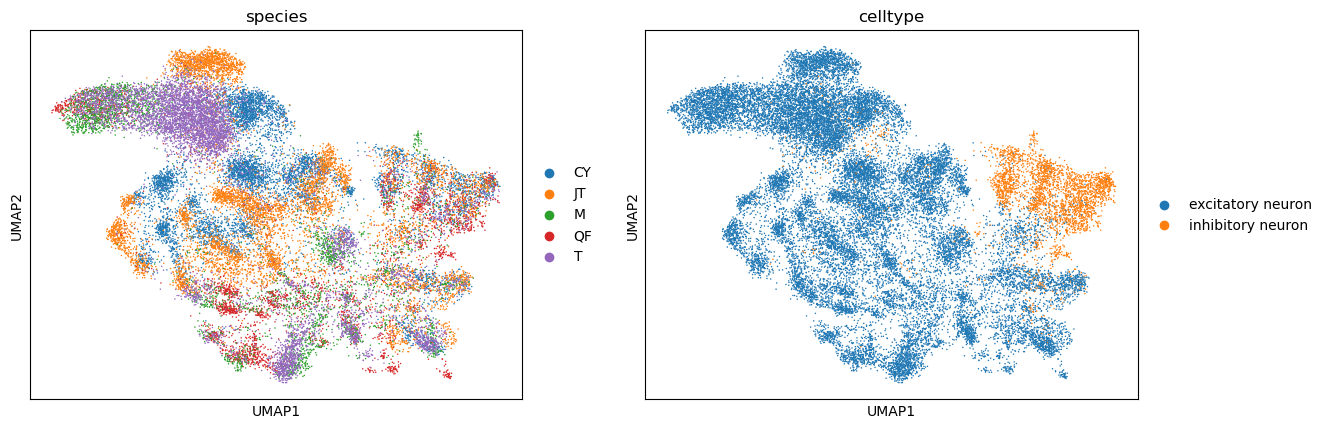

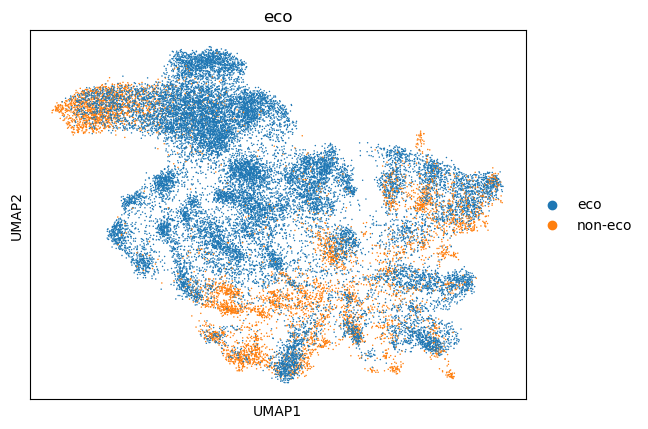

C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\2012969562.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(neuron, resolution= 0.5)


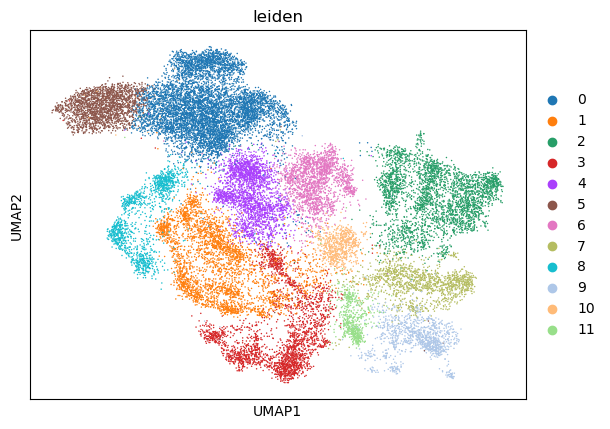

samples  CYHM  JTHM  MHM  QFHM   THM
leiden                              
0        1446  1422  249    76  3359
1         973  1146  257   559   237
2        1017   892  214   711   291
3          12   252  646   667   880
4        1210  1037    7    13   116
5           0    10  899   412   673
6         817   903   34    12    75
7         306   528  186   108   210
8         686   592    6    17    33
9         203   234  139   196   333
10         53    38  302    23   265
11          0     5  158   151   271


C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


In [4]:
neuron = pipe_1(neuron, 0.1, 2.2,True)
sc.tl.leiden(neuron, resolution= 0.5)
sc.pl.umap(neuron, color = 'leiden')
print(count_summary(neuron, 'leiden' , key_2 = 'samples'))

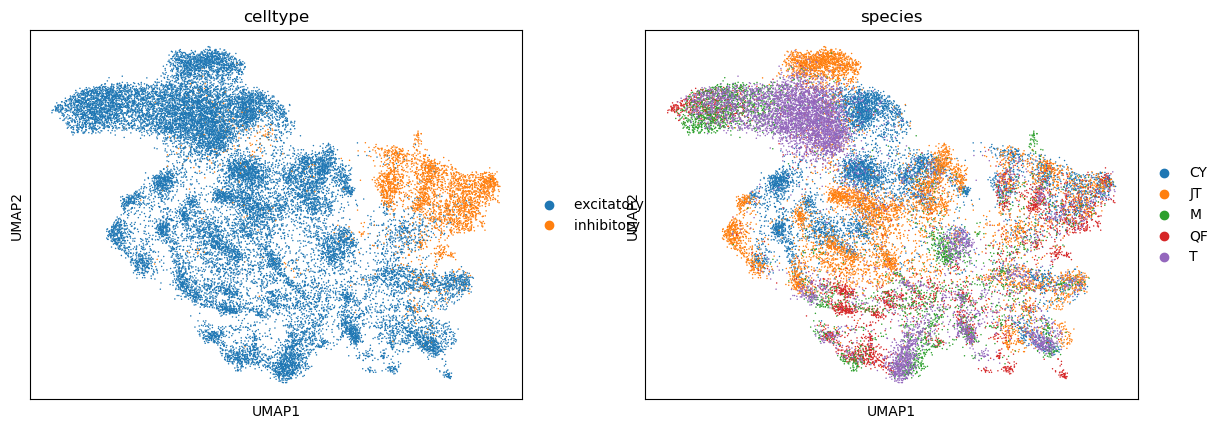

In [5]:
sc.pl.umap(neuron, color = ['celltype','species'])

In [6]:
count_summary(neuron, 'leiden', 'species')

C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


species    CY    JT    M   QF     T
leiden                             
0        1446  1422  249   76  3359
1         973  1146  257  559   237
2        1017   892  214  711   291
3          12   252  646  667   880
4        1210  1037    7   13   116
5           0    10  899  412   673
6         817   903   34   12    75
7         306   528  186  108   210
8         686   592    6   17    33
9         203   234  139  196   333
10         53    38  302   23   265
11          0     5  158  151   271

345
(26222, 2670)


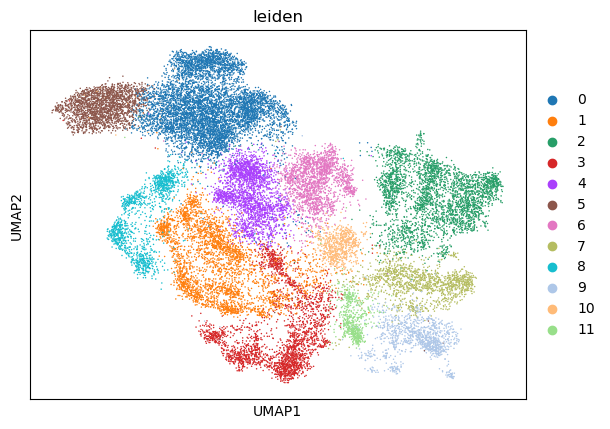

samples  CYHM  JTHM  MHM  QFHM   THM
leiden                              
0        1446  1422    0     0  3359
1         973  1146  257   559   237
2        1017   892  214   711   291
3          12   252  646   667   880
4        1210  1037    0     0   116
5           0    10  899   412   673
6         817   903   34    12    75
7         306   528  186   108   210
8         686   592    6    17    33
9         203   234  139   196   333
10         53    38  302    23   265
11          0     5  158   151   271


C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([key_1, key_2]).size().reset_index(name='count')
C:\Users\sunrui\AppData\Local\Temp\ipykernel_14080\3895147484.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(key_2).size().reset_index(name='total_count')


In [8]:
drop_id_1 = np.logical_and(neuron.obs.leiden.values == '0' , neuron.obs.eco.values == 'non-eco')
drop_id_2 = np.logical_and(neuron.obs.leiden.values == '4' , neuron.obs.eco.values == 'non-eco')
drop_id = np.logical_or(drop_id_1, drop_id_2)
print(drop_id.sum())
neuron = neuron[~drop_id,:]
print(neuron.shape) 
sc.pl.umap(neuron, color = 'leiden')
print(count_summary(neuron, 'leiden' , key_2 = 'samples'))

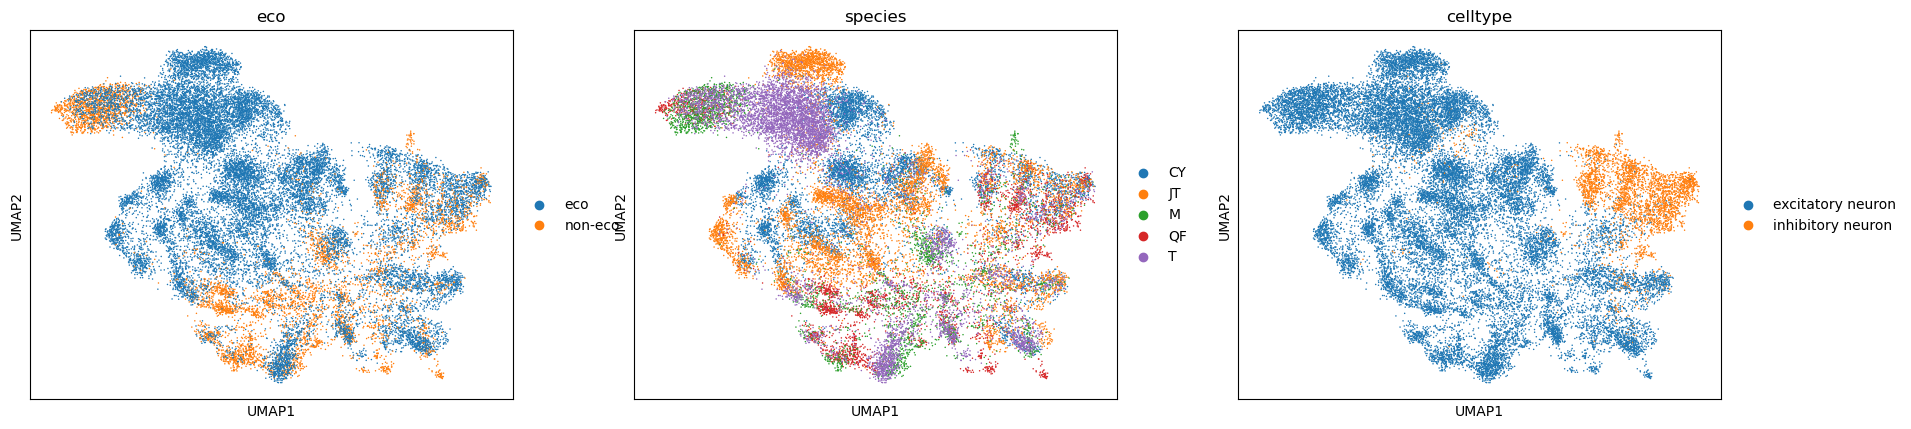

In [45]:
sc.pl.umap(neuron, color = ['eco','species','celltype'])

In [ ]:
#neuron.write('final_hvg.h5ad')